In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Image to patches


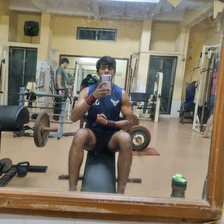

In [ ]:
image = Image.open('/content/Gym.jpg').resize((224, 224), Image.Resampling.LANCZOS)
image

array([[[117,  97,  58],
        [116,  96,  56],
        [113,  94,  54],
        ...,
        [ 75,  59,  38],
        [ 79,  63,  41],
        [ 98,  80,  56]],

       [[125, 106,  63],
        [120,  99,  57],
        [115,  96,  54],
        ...,
        [102,  90,  70],
        [ 90,  75,  52],
        [ 87,  71,  48]],

       [[128, 108,  65],
        [125, 104,  61],
        [120, 101,  59],
        ...,
        [151, 145, 120],
        [135, 127, 104],
        [114, 104,  78]],

       ...,

       [[180, 181, 186],
        [177, 180, 185],
        [179, 182, 187],
        ...,
        [175, 167, 145],
        [189, 181, 159],
        [189, 181, 159]],

       [[178, 180, 185],
        [177, 180, 186],
        [180, 183, 189],
        ...,
        [175, 167, 149],
        [181, 173, 154],
        [185, 177, 158]],

       [[180, 182, 187],
        [179, 182, 188],
        [180, 183, 190],
        ...,
        [177, 168, 150],
        [182, 174, 155],
        [184, 176, 157]]], dtype=uint8)
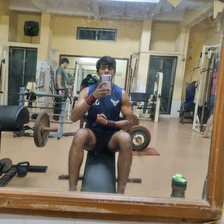

In [ ]:
X = np.array(image)
X

In [ ]:
p = 16
c = 3

patches = X.reshape(X.shape[0] // p, p, X.shape[1] // p, p, c).reshape(-1, p, p, c)
patches.shape

(196, 16, 16, 3)

In [ ]:
X_p = np.reshape(patches, (-1,p*p*c))
X_p.shape

(196, 768)

In [ ]:
# Number of patches
N = X_p.shape[0]
N

196

## 2. Embedding of patches

In [ ]:
D = 768
B = 1
X_p = torch.tensor(X_p, dtype=torch.float32)
X_p = X_p[None,...]
E = nn.Parameter(torch.randn(1, p*p*c, D))
patch_embedding = torch.matmul(X_p, E)
patch_embedding.shape

torch.Size([1, 196, 768])

## 3. Class token


In [ ]:
class_token = nn.Parameter(torch.randn(1, 1, D))
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedding = torch.cat([class_token, patch_embedding], dim=1)
patch_embedding.shape

torch.Size([1, 197, 768])

## 4. Positional Embedding

In [ ]:
E_pos = nn.Parameter(torch.randn(1, N+1, D))
E_pos.shape

torch.Size([1, 197, 768])

In [ ]:
# Z0 = [class_token; X_p[0]*E; X_p[1]*E;....;X[N-1]*E] + E_pos
z0 = patch_embedding + E_pos
z0.shape

torch.Size([1, 197, 768])

## 5. Self Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, key_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.key_dim = key_dim
        self.W = nn.Parameter(torch.randn(embedding_dim, 3 * key_dim))

    def forward(self, X):
        key_dim = self.key_dim
        qkv = torch.matmul(X, self.W)
        batch_size, seq_len, _ = qkv.shape

        q = qkv[:, :, :key_dim]
        k = qkv[:, :, key_dim:2*key_dim]
        v = qkv[:, :, 2*key_dim:]

        k_T = k.transpose(-2, -1)
        dot_products = torch.matmul(q, k_T)
        scaled_dot_products = dot_products / np.sqrt(key_dim)
        attention_weights = F.softmax(scaled_dot_products, dim=-1)

        attention = torch.matmul(attention_weights, v)
        return attention

In [ ]:
D_h = 64
self_attention = SelfAttention(D, D_h)
attention = self_attention(patch_embedding)
print(attention.shape)

torch.Size([1, 197, 64])


## 6. Multi head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=8):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        assert embedding_dim % num_heads == 0
        self.key_dim = embedding_dim // num_heads
        self.attention_list = [SelfAttention(embedding_dim,self.key_dim) for _ in range(num_heads)]
        self.multihead_attention = nn.ModuleList(self.attention_list)
        self.W = nn.Parameter(torch.randn(num_heads * self.key_dim, embedding_dim))
    def forward(self, X):
        attention_scores = [attention(X) for attention in self.multihead_attention]
        Z = torch.cat(attention_scores, dim=-1)
        attention_score = torch.matmul(Z, self.W)
        return attention_score

In [ ]:
n_head = 12
multi_head_attention = MultiHeadAttention(D, n_head)
attention_score = multi_head_attention(patch_embedding)
print(attention_score.shape)

torch.Size([1, 197, 768])


## 7. Multi layer perceptron
MLP(x) = GELU(xW1 + b1)W2 + b2

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, embedding_dim=768, mlp_dim=3072):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embedding_dim)
        )
    def forward(self, X):
        return self.mlp(X)

In [ ]:
hidden_dim = 3072
mlp = MultilayerPerceptron(D, hidden_dim)
mlp_out = mlp(attention_score)
print(mlp_out.shape)

torch.Size([1, 197, 768])


## 8 Layer Normalization

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, eps:float = 10*6) -> None:
        super().__init__()
        self.eps = E_pos
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, X):
      mean = X.mean(dim=-1, keepdim=True)
      std = X.std(dim=-1, keepdim=True)
      return self.alpha * (X - mean) / (std + self.eps) + self.bias

## 9 Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=8, mlp_dim=3072, dropout_prob = 0.1):
    super().__init__()
    self.MSA = MultiHeadAttention(embedding_dim, num_heads)
    self.MLP = MultilayerPerceptron(embedding_dim, mlp_dim)
    self.LN1 = nn.LayerNorm(embedding_dim)
    self.LN2 = nn.LayerNorm(embedding_dim)
    self.dropout1 = nn.Dropout(dropout_prob)
    self.dropout2 = nn.Dropout(dropout_prob)
    self.dropout3 = nn.Dropout(dropout_prob)

  def forward(self, X):
    out_1 = self.dropout1(X)
    out_2 = self.LN1(out_1)
    msa_out = self.MSA(out_2)
    out_3 = self.dropout2(msa_out)
    res_out = X + out_3
    out_4 = self.LN2(res_out)
    mlp_out = self.MLP(out_4)
    out_5 = self.dropout3(mlp_out)
    output = res_out + out_5
    return output

In [ ]:
dropout_prob = 0.1
transformer_encoder = TransformerEncoder(D, n_head, hidden_dim, dropout_prob)
output = transformer_encoder(patch_embedding)
print(output.shape)

torch.Size([1, 197, 768])


In [ ]:
output[0][1]

tensor([-4.4694e+03, -7.4718e+03, -2.7999e+03, -6.2332e+03, -1.4969e+03,
         2.9377e+03,  3.0216e+03,  2.5425e+03, -4.5070e+03, -1.8286e+03,
        -3.5972e+03,  1.2627e+03,  1.9816e+03,  9.7098e+03,  1.7066e+03,
         3.0527e+03, -1.5918e+02, -1.0716e+03,  6.3685e+03, -1.9739e+03,
        -6.2056e+03,  2.8111e+03, -4.9672e+03, -2.3377e+02, -1.6631e+03,
         2.1584e+03,  3.7211e+03, -5.5223e+03, -3.1700e+03,  5.4879e+03,
        -1.0178e+04,  4.3832e+03,  1.2272e+03,  3.2434e+03, -2.4636e+03,
        -1.4345e+03, -2.0988e+03, -3.1555e+03, -5.2313e+02, -1.1095e+02,
        -4.7180e+03, -9.2523e+03, -4.1157e+03,  2.0731e+03, -1.9198e+03,
        -5.8477e+02, -1.5544e+04, -6.2179e+02,  2.7423e+02, -4.5132e+03,
         1.6738e+03, -5.5811e+02,  8.5967e+03, -2.3849e+03, -6.6046e+03,
        -5.1219e+03,  2.0256e+03,  6.1009e+03, -1.5992e+03,  3.1511e+03,
         9.3165e+02,  5.5441e+03,  3.4082e+03,  5.6033e+03, -1.0337e+03,
         3.8916e+03,  1.3588e+03,  1.0489e+03, -1.7

## 10. MLP Head (Classification head)